In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import poisson

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the lambda(t) function
def lambda_t(t):
    return (1/56) * (-5*(t - 7)**3 + 90*(t - 7)**2 - 300*(t - 7) + 760)




In [2]:
# Step 1: Integrate lambda(t) from t=7 to t=19
Lambda, _ = quad(lambda_t, 7, 19)
print(f"Expected number of arrivals (Λ): {Lambda:.2f}")

Expected number of arrivals (Λ): 240.00


In [3]:
# Step 2: Calculate the probability N > 250
prob = 1 - poisson.cdf(250, Lambda)
print(f"P(N > 250) = {prob:.4f}")

P(N > 250) = 0.2471


In [4]:
1-prob

0.752887467940433

### B

In [6]:
# Step 1: Set simulation parameters
a, b = 7, 19                   # time interval in hours
num_days = 500                 # number of realizations
dt = b - a
time_resolution = 1_000         # fine granularity for estimating max lambda
t_vals = np.linspace(a, b, time_resolution)
lambda_vals = lambda_t(t_vals)
lambda_max = np.max(lambda_vals)

print(f"Max lambda(t): {lambda_max:.2f}")


Max lambda(t): 31.43


100%|██████████| 500/500 [00:00<00:00, 11258.49it/s]


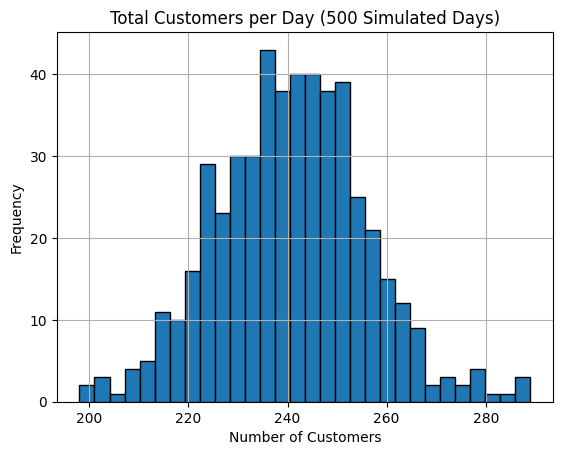

Estimated P(N > 250): 0.2500
95% CI for P(N > 250): (0.2120, 0.2880)


In [7]:

# Step 2: Run simulation using thinning
total_arrivals_per_day = []

for _ in tqdm(range(num_days)):
    # 1. Simulate number of candidate points from homogeneous Poisson process
    n_candidates = np.random.poisson(lam=lambda_max * dt)
    
    # 2. Generate uniform candidate times in [a, b]
    candidate_times = np.random.uniform(low=a, high=b, size=n_candidates)
    
    # 3. Compute acceptance probabilities
    probs = lambda_t(candidate_times) / lambda_max
    
    # 4. Accept or reject each point
    uniform_randoms = np.random.uniform(size=n_candidates)
    accepted_times = candidate_times[uniform_randoms < probs]
    
    # 5. Store number of arrivals for this day
    total_arrivals_per_day.append(len(accepted_times))

# Step 3: Plot histogram of arrivals
plt.hist(total_arrivals_per_day, bins=30, edgecolor='black')
plt.title("Total Customers per Day (500 Simulated Days)")
plt.xlabel("Number of Customers")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 4: Estimate P(N > 250)
arrivals = np.array(total_arrivals_per_day)
prob_more_than_250 = np.mean(arrivals > 250)
print(f"Estimated P(N > 250): {prob_more_than_250:.4f}")

# Step 5: Compute 95% confidence interval
mean_estimate = np.mean(arrivals > 250)
std_error = np.sqrt(mean_estimate * (1 - mean_estimate) / num_days)
ci_lower = mean_estimate - 1.96 * std_error
ci_upper = mean_estimate + 1.96 * std_error

print(f"95% CI for P(N > 250): ({ci_lower:.4f}, {ci_upper:.4f})")


100%|██████████| 5000/5000 [00:00<00:00, 6503.62it/s]


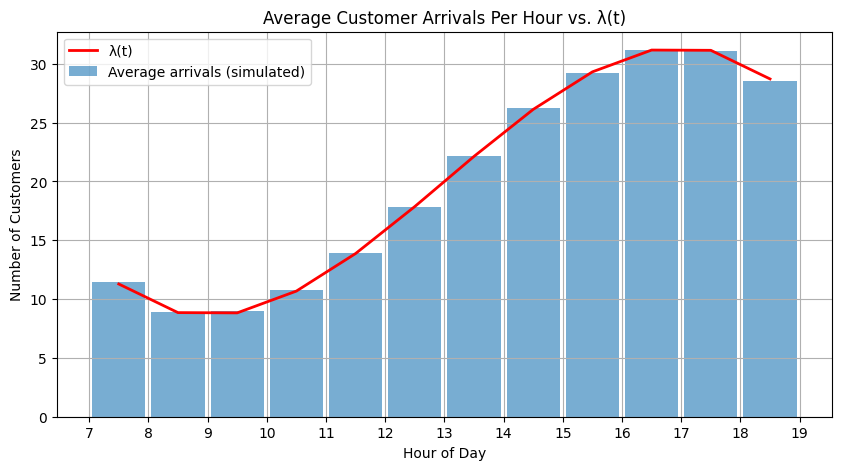

In [8]:
# Simulation settings
a, b = 7, 19  # hours of operation
num_days = 5_000
lambda_max = np.max(lambda_t(np.linspace(a, b, 1000)))
hour_bins = np.arange(7, 20)  # 13 hourly bins from 7 to 19 (exclusive)
hourly_counts = np.zeros((num_days, len(hour_bins) - 1))

# Simulate arrivals for 500 days
for day in tqdm(range(num_days)):
    # Step 1: simulate total number of candidate arrivals
    n_candidates = np.random.poisson(lambda_max * (b - a))
    
    # Step 2: generate candidate arrival times uniformly
    candidate_times = np.random.uniform(a, b, n_candidates)
    
    # Step 3: accept/reject based on thinning
    probs = lambda_t(candidate_times) / lambda_max
    accept = np.random.uniform(size=n_candidates) < probs
    arrivals = candidate_times[accept]
    
    # Step 4: histogram the accepted times into hourly bins
    counts, _ = np.histogram(arrivals, bins=hour_bins)
    hourly_counts[day] = counts

# Step 5: Compute the average number of arrivals per hour
average_hourly = np.mean(hourly_counts, axis=0)
hours = np.arange(7.5, 19, 1)  # center of each hourly bin

# Step 6: Evaluate λ(t) at bin centers for overlay
lambda_values = lambda_t(hours)

# Step 7: Plotting
plt.figure(figsize=(10, 5))
plt.bar(hours, average_hourly, width=0.9, alpha=0.6, label="Average arrivals (simulated)")
plt.plot(hours, lambda_values, color='red', label="λ(t)", linewidth=2)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Customers")
plt.title("Average Customer Arrivals Per Hour vs. λ(t)")
plt.legend()
plt.grid(True)
plt.xticks(np.arange(7, 20, 1))
plt.show()
